In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
!pip install keras-tuner
!pip install tensorflow_addons
import tensorflow_addons as tfa
#from tensorflow.keras import mixed_precision
import keras_tuner as kt
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)
keras.utils.set_random_seed(9)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
injury_history = pd.read_csv('/content/drive/MyDrive/data_490/injury_data/injury_history')
bio_data = pd.read_csv('/content/drive/MyDrive/data_490/processed_data/bio_data.csv')
ts_data = pd.read_pickle('/content/drive/MyDrive/data_490/processed_data/thirty_day_timestep_df')

In [3]:
bio_data.player_age = bio_data['player_age'].str.split(' ').str[0]

In [4]:
indexes = np.random.permutation(len(ts_data))
train_size = int(len(indexes)*.8)
valid_size = int(train_size*.2)
train_indexes = indexes[valid_size:train_size]
valid_indexes = indexes[:valid_size]
test_indexes = indexes[train_size:]

In [5]:
bio_data = bio_data.fillna(-1)
injury_history = injury_history.fillna(-1)

In [6]:
ts_train = np.stack(ts_data.loc[train_indexes, 'time_series'].values).astype(np.float16)[:,:,:-1]
ts_valid = np.stack(ts_data.loc[valid_indexes, 'time_series'].values).astype(np.float16)[:,:,:-1]
ts_test = np.stack(ts_data.loc[test_indexes, 'time_series'].values).astype(np.float16)[:,:,:-1]
bio_train = bio_data.iloc[train_indexes, 2:].astype(np.float16)
bio_valid = bio_data.iloc[valid_indexes, 2:].astype(np.float16)
bio_test = bio_data.iloc[test_indexes, 2:].astype(np.float16)
injury_train = injury_history.iloc[train_indexes, 2:].astype(np.float16)
injury_valid = injury_history.iloc[valid_indexes, 2:].astype(np.float16)
injury_test = injury_history.iloc[test_indexes, 2:].astype(np.float16)
train_target =  ts_data.loc[train_indexes, 'injured'].astype(np.float16)
valid_target =  ts_data.loc[valid_indexes, 'injured'].astype(np.float16)
test_target = ts_data.loc[test_indexes, 'injured'].astype(np.float16)

In [7]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, dropout=0, time_steps=30, features=85):
        super().__init__()
        self.dropout = layers.Dropout(dropout)
        p = np.zeros(np.shape((1, time_steps, features)))
        columns = np.arange(features)
        rows = np.arange(time_steps)
        p = rows.reshape(-1,1)/1000**(columns*2/features)
        p[:, 0::2] = np.sin(p[:,0::2])
        p[:, 1::2] = np.cos(p[:, 1::2])
        self.p = p

    def call(self, x, **kwargs):
        x = x + self.p
        return self.dropout(x)

In [8]:
from re import X
def transformer_encoder(inputs, head_size, num_heads, conv_filters, kernel_size, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=conv_filters, kernel_size=kernel_size, activation="relu", padding='same')(x)
    X = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [9]:
def build_mixed_model(
    ts_input_shape,
    injury_input_shape,
    bio_input_shape,
    head_size=256,
    num_heads=8,
    conv_filters=64,
    kernel_size=3,
    num_transformer_blocks=4,
    mlp_units=128,
    mlp_layers=2,
    encoder_dropout=0,
    mlp_dropout=0,
    pe_dropout=0,
    embedding_dropout=0,
    pe=True,
    embedding=True,
):
    ts_input = keras.Input(shape=ts_input_shape)
    x = ts_input
    x = keras.layers.Normalization(axis=1)(x)
    
    #Embedding
    if embedding:
      x = layers.Flatten(input_shape=ts_input_shape)(x)
      x = layers.Dense(ts_input_shape[-1]*ts_input_shape[-2], activation='tanh')(x)
      x = layers.Dropout(embedding_dropout)(x)
      x = layers.Reshape(ts_input_shape)(x)

    #Positional Encoding
    if pe:
      x = PositionalEncoding()(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, conv_filters, kernel_size, encoder_dropout)


    bio_input = keras.Input(shape=bio_input_shape)
    bio = layers.experimental.preprocessing.Normalization()(bio_input)

    injury_input = keras.Input(shape=injury_input_shape) 
    injury = layers.experimental.preprocessing.Normalization()(injury_input)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    x = tf.keras.layers.Concatenate()([x, injury, bio])

    for i in range(mlp_layers):
        x = layers.Dense(mlp_units, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    inputs = [ts_input, injury_input, bio_input]
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [10]:
ts_shape = np.shape(ts_train)[1:]
injury_shape = np.shape(injury_train)[1:]
bio_shape = np.shape(bio_train)[1:]

model = build_mixed_model(
    ts_shape,
    injury_shape,
    bio_shape,
    head_size=256,
    num_heads=32,
    conv_filters=32,
    kernel_size=3,
    num_transformer_blocks=5,
    mlp_units=128,
    mlp_layers=4,
    encoder_dropout=.28,
    mlp_dropout=.15,
    pe_dropout=.25,
    embedding_dropout=.07,
    pe=True,
    embedding=False
)

In [11]:
opt = keras.optimizers.Adam(learning_rate=9e-5)
opt = tfa.optimizers.SWA(opt, start_averaging=20, average_period=1)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=opt,
    metrics=[keras.metrics.AUC()],
    steps_per_execution=64,
    jit_compile=True
)

In [12]:
def scheduler(epoch, lr, warmup_epochs=20, decay_epochs=100, initial_lr=1e-10, base_lr=1e-4, min_lr=1e-8):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr
    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [13]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, monitor='val_auc', mode='max', restore_best_weights=False),
             tf.keras.callbacks.LearningRateScheduler(scheduler)]

history = model.fit([ts_train, injury_train, bio_train],
            train_target,
           validation_data=[[ts_valid, injury_valid, bio_valid], valid_target],
           epochs=500, callbacks=callbacks,
           batch_size=16)

Epoch 1/500
5291/5291 [==============================] - 305s 58ms/step - loss: 222.9375 - auc: 0.4963 - val_loss: 66.2619 - val_auc: 0.4362 - lr: 1.0000e-10
Epoch 2/500
5291/5291 [==============================] - 247s 47ms/step - loss: 22.1640 - auc: 0.4963 - val_loss: 12.2213 - val_auc: 0.4987 - lr: 5.0001e-06
Epoch 3/500
5291/5291 [==============================] - 246s 46ms/step - loss: 9.8290 - auc: 0.5011 - val_loss: 5.1648 - val_auc: 0.4987 - lr: 1.0000e-05
Epoch 4/500
5291/5291 [==============================] - 247s 47ms/step - loss: 4.9306 - auc: 0.5012 - val_loss: 1.9190 - val_auc: 0.4984 - lr: 1.5000e-05
Epoch 5/500
5291/5291 [==============================] - 249s 47ms/step - loss: 2.6809 - auc: 0.5026 - val_loss: 0.6009 - val_auc: 0.4978 - lr: 2.0000e-05
Epoch 6/500
5291/5291 [==============================] - 255s 48ms/step - loss: 1.4750 - auc: 0.5017 - val_loss: 0.4323 - val_auc: 0.4997 - lr: 2.5000e-05
Epoch 7/500
5291/5291 [==============================] - 259s 49m

In [14]:
pred = model.predict([ts_test, injury_test, bio_test])
high_risk = np.where(pred > np.percentile(pred, 98))
normal_risk = np.where((pred > np.percentile(pred, 40)) & (pred < np.percentile(pred, 98)))
low_risk = np.where(pred < np.percentile(pred, 40))
print(f'high risk injury rate: {np.mean(test_target.iloc[high_risk[0]])}')
print(f'normal risk injury rate: {np.mean(test_target.iloc[normal_risk[0]])}')
print(f'low risk injury rate: {np.mean(test_target.iloc[low_risk[0]])}')

high risk injury rate: 0.06036376953125
normal risk injury rate: 0.024383544921875
low risk injury rate: 0.00415802001953125


In [15]:
valid_pred = model.predict([ts_valid, injury_valid, bio_valid])
high_risk = np.where(valid_pred > np.percentile(valid_pred, 98))
normal_risk = np.where((valid_pred > np.percentile(valid_pred, 40)) & (valid_pred < np.percentile(valid_pred, 98)))
low_risk = np.where(valid_pred < np.percentile(valid_pred, 40))
print(f'high risk injury rate: {np.mean(valid_target.iloc[high_risk[0]])}')
print(f'normal risk injury rate: {np.mean(valid_target.iloc[normal_risk[0]])}')
print(f'low risk injury rate: {np.mean(valid_target.iloc[low_risk[0]])}')

high risk injury rate: 0.04718017578125
normal risk injury rate: 0.024932861328125
low risk injury rate: 0.005199432373046875


In [16]:
train_pred = model.predict([ts_train, injury_train, bio_train])
high_risk = np.where(train_pred > np.percentile(train_pred, 98))
normal_risk = np.where((train_pred > np.percentile(train_pred, 40)) & (train_pred < np.percentile(train_pred, 98)))
low_risk = np.where(train_pred < np.percentile(train_pred, 40))
print(f'high risk injury rate: {np.mean(train_target.iloc[high_risk[0]])}')
print(f'normal risk injury rate: {np.mean(train_target.iloc[normal_risk[0]])}')
print(f'low risk injury rate: {np.mean(train_target.iloc[low_risk[0]])}')

high risk injury rate: 0.057281494140625
normal risk injury rate: 0.0239410400390625
low risk injury rate: 0.0024509429931640625


In [17]:
pred = model.predict([ts_test, injury_test, bio_test])
test_high_risk = np.where(pred > np.percentile(train_pred, 98))
test_normal_risk = np.where((pred > np.percentile(train_pred, 25)) & (pred < np.percentile(train_pred, 75)))
test_low_risk = np.where(pred < np.percentile(train_pred, 40))
print(f'high risk injury rate: {np.mean(test_target.iloc[test_high_risk[0]])}')
print(f'normal risk injury rate: {np.mean(test_target.iloc[test_normal_risk[0]])}')
print(f'low risk injury rate: {np.mean(test_target.iloc[test_low_risk[0]])}')

high risk injury rate: 0.0604248046875
normal risk injury rate: 0.0164642333984375
low risk injury rate: 0.0038280487060546875


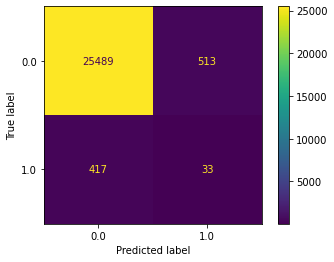

In [18]:
from sklearn import metrics
predictions = np.zeros(len(test_target), dtype=int)
predictions[test_high_risk[0]] = 1
metrics.ConfusionMatrixDisplay.from_predictions(test_target, predictions)

In [22]:
model.save('/content/drive/MyDrive/data_490/injury_data/final_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_490/injury_data/final_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_490/injury_data/final_model/assets


In [20]:
metrics.f1_score(test_target, predictions)

0.06626506024096386